<a href="https://colab.research.google.com/github/lisboaeric/ProjetoMachineLearning/blob/main/SalaryData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Simport pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import shap

In [ ]:
df = pd.read_csv('Salary_Data.csv')

mapping = {
    "Bachelor's": "Bachelor's Degree",
    "Bachelor's Degree": "Bachelor's Degree",
    "Master's": "Master's Degree",
    "Master's Degree": "Master's Degree",
    'PhD': 'PhD',
    'phD': 'PhD',
    'High School': 'High School'
}

df['Education Level'] = df['Education Level'].map(mapping)
median_age = df['Age'].median()
mode_gender = df['Gender'].mode()[0]
mode_education = df['Education Level'].mode()[0]
median_exp = df['Years of Experience'].median()
median_salary = df['Salary'].median()



df.fillna({
    'Age': median_age,
    'Education Level': mode_education,
    'Gender': mode_gender,
    'Job Title': 'Unknown',
    'Years of Experience': median_exp,
    'Salary': median_salary
}, inplace=True)


df['Experience/Age Ratio'] = df['Years of Experience'] / (df['Age'] - 18)
bins = [0, 0.5, 1, float('inf')]
labels = ['Abaixo', 'Padrão', 'Acima']
df['ExpAgeNivel'] = pd.cut(df['Experience/Age Ratio'], bins=bins, labels=labels, include_lowest=True)

conditions = [
    (df['Years of Experience'] <= 5),
    (df['Years of Experience'] > 5) & (df['Years of Experience'] <= 10),
    (df['Years of Experience'] > 10)
]

choices = ['Junior', 'Senior', 'Pleno']

df['Seniority'] = np.select(conditions, choices, default='Unknown')
df['Seniority'] = pd.Categorical(df['Seniority'], categories=['Junior', 'Senior', 'Pleno'], ordered=True)



print("Valores faltantes totais:", df.isnull().sum().sum())
print("\nValores faltantes por coluna:")

print(df.isnull().sum())


Valores faltantes totais: 0

Valores faltantes por coluna:
Age                     0
Gender                  0
Education Level         0
Job Title               0
Years of Experience     0
Salary                  0
Experience/Age Ratio    0
ExpAgeNivel             0
Seniority               0
dtype: int64


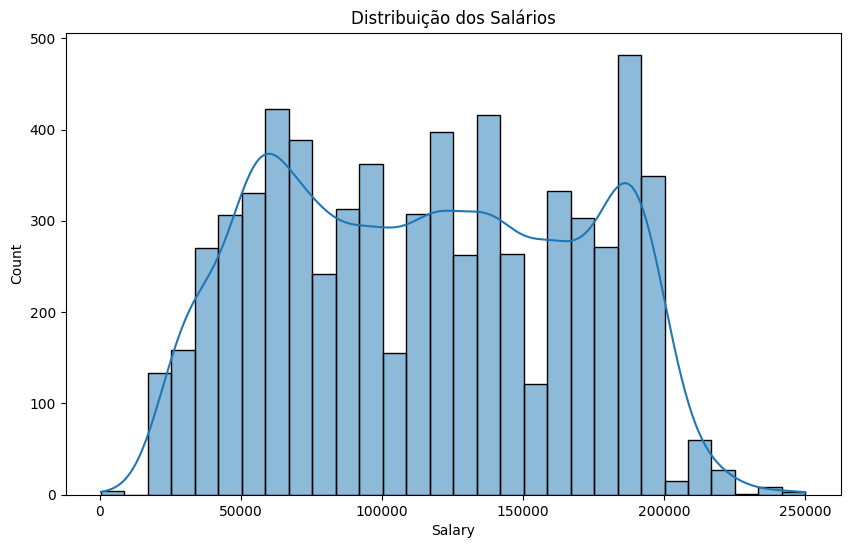

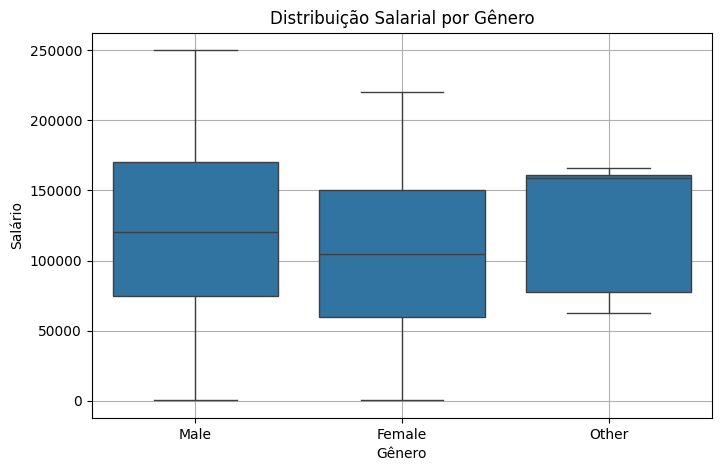

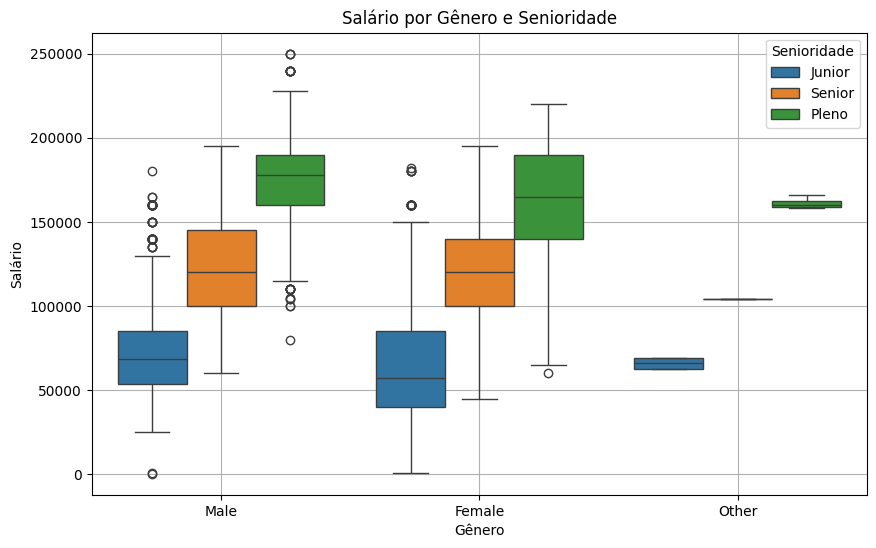

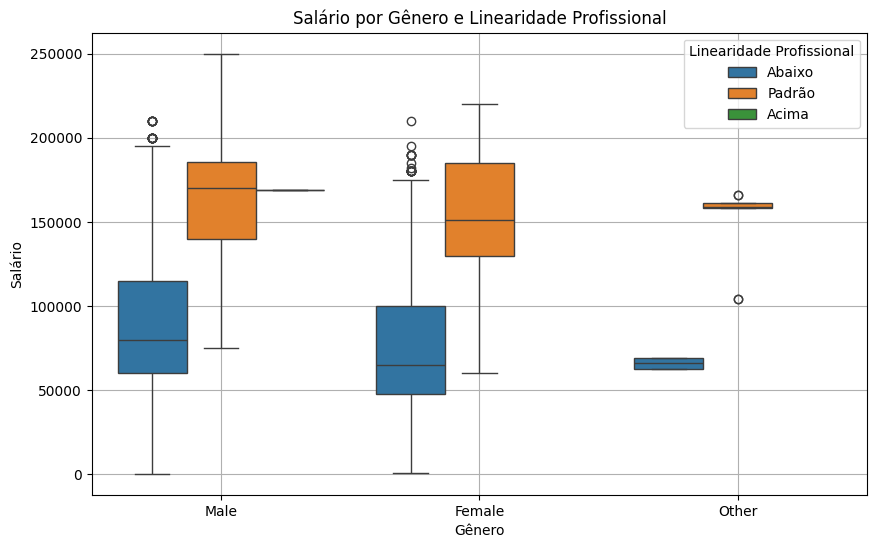

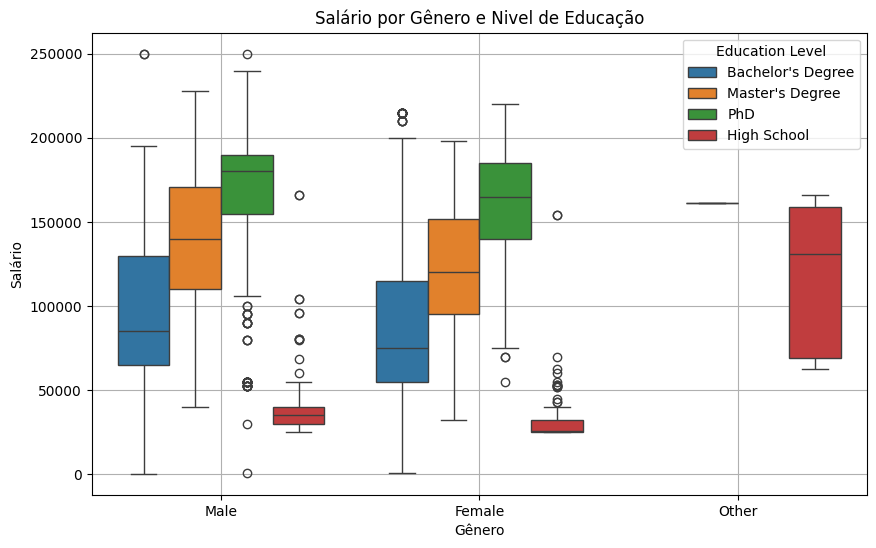

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Salary'], bins=30, kde=True)
plt.title('Distribuição dos Salários')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Gender", y="Salary")
plt.title("Distribuição Salarial por Gênero")
plt.ylabel("Salário")
plt.xlabel("Gênero")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Gender", y="Salary", hue="Seniority")
plt.title("Salário por Gênero e Senioridade")
plt.ylabel("Salário")
plt.xlabel("Gênero")
plt.grid(True)
plt.legend(title="Senioridade")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Gender", y="Salary", hue="ExpAgeNivel")
plt.title("Salário por Gênero e Linearidade Profissional")
plt.ylabel("Salário")
plt.xlabel("Gênero")
plt.grid(True)
plt.legend(title="Linearidade Profissional")
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Gender", y="Salary", hue="Education Level")
plt.title("Salário por Gênero e Nivel de Educação")
plt.ylabel("Salário")
plt.xlabel("Gênero")
plt.grid(True)
plt.legend(title="Education Level")
plt.show()



In [ ]:
X = df.drop('Salary', axis=1)
y = df['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = ['Age', 'Years of Experience', 'Experience/Age Ratio']
categorical_features = ['Gender', 'Education Level', 'Job Title', 'Seniority','ExpAgeNivel']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_search)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [ ]:

media_salarial = df['Salary'].mean()
print("\nMétricas de avaliação:")
print(f"Media Salarial: {media_salarial:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")


Métricas de avaliação:
Media Salarial: 115326.72
MAE: 3597.54
MSE: 79328785.38
RMSE: 8906.67
R²: 0.9703


<ipython-input-171-d744daee603d>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color = 'black')


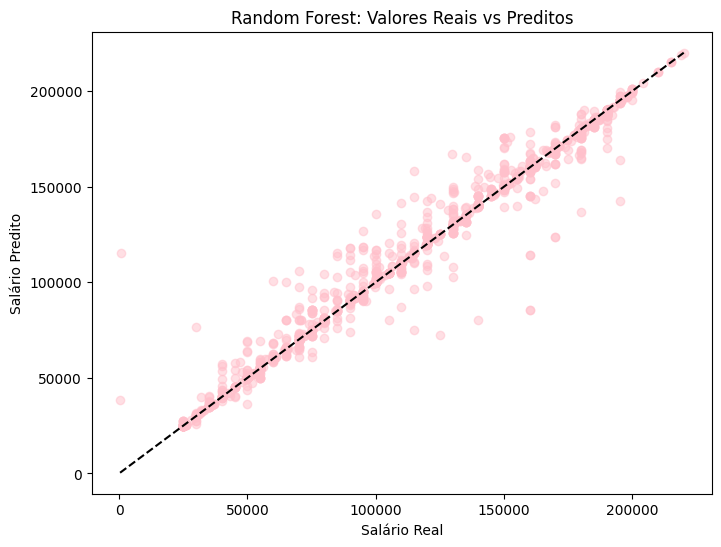

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5,color = 'pink')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color = 'black')
plt.xlabel('Salário Real')
plt.ylabel('Salário Predito')
plt.title('Random Forest: Valores Reais vs Preditos')
plt.show()

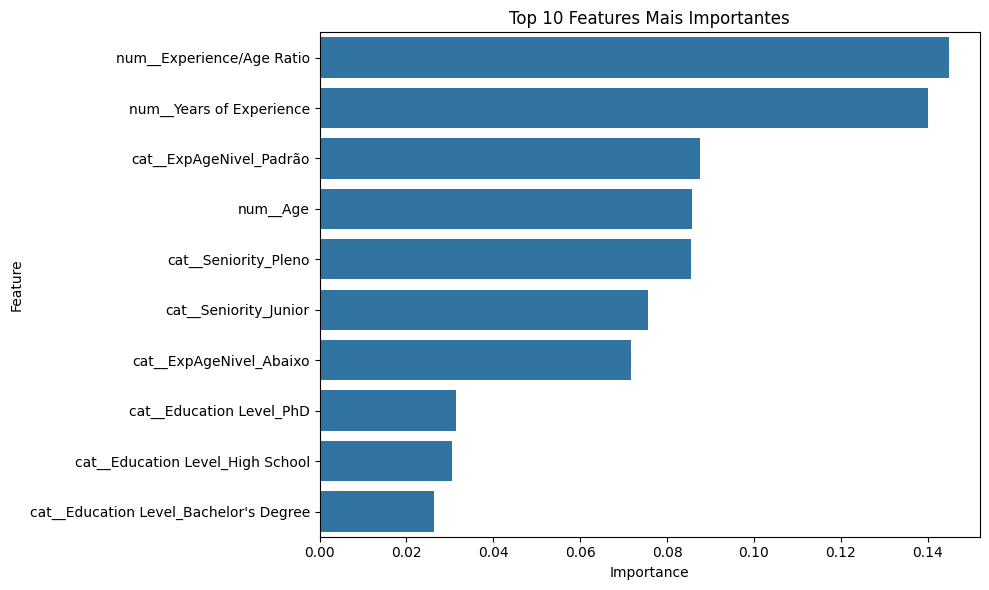

In [ ]:
# Importância das features
feature_importances = pipeline.named_steps['model'].best_estimator_.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Features Mais Importantes')
plt.tight_layout()
plt.show()

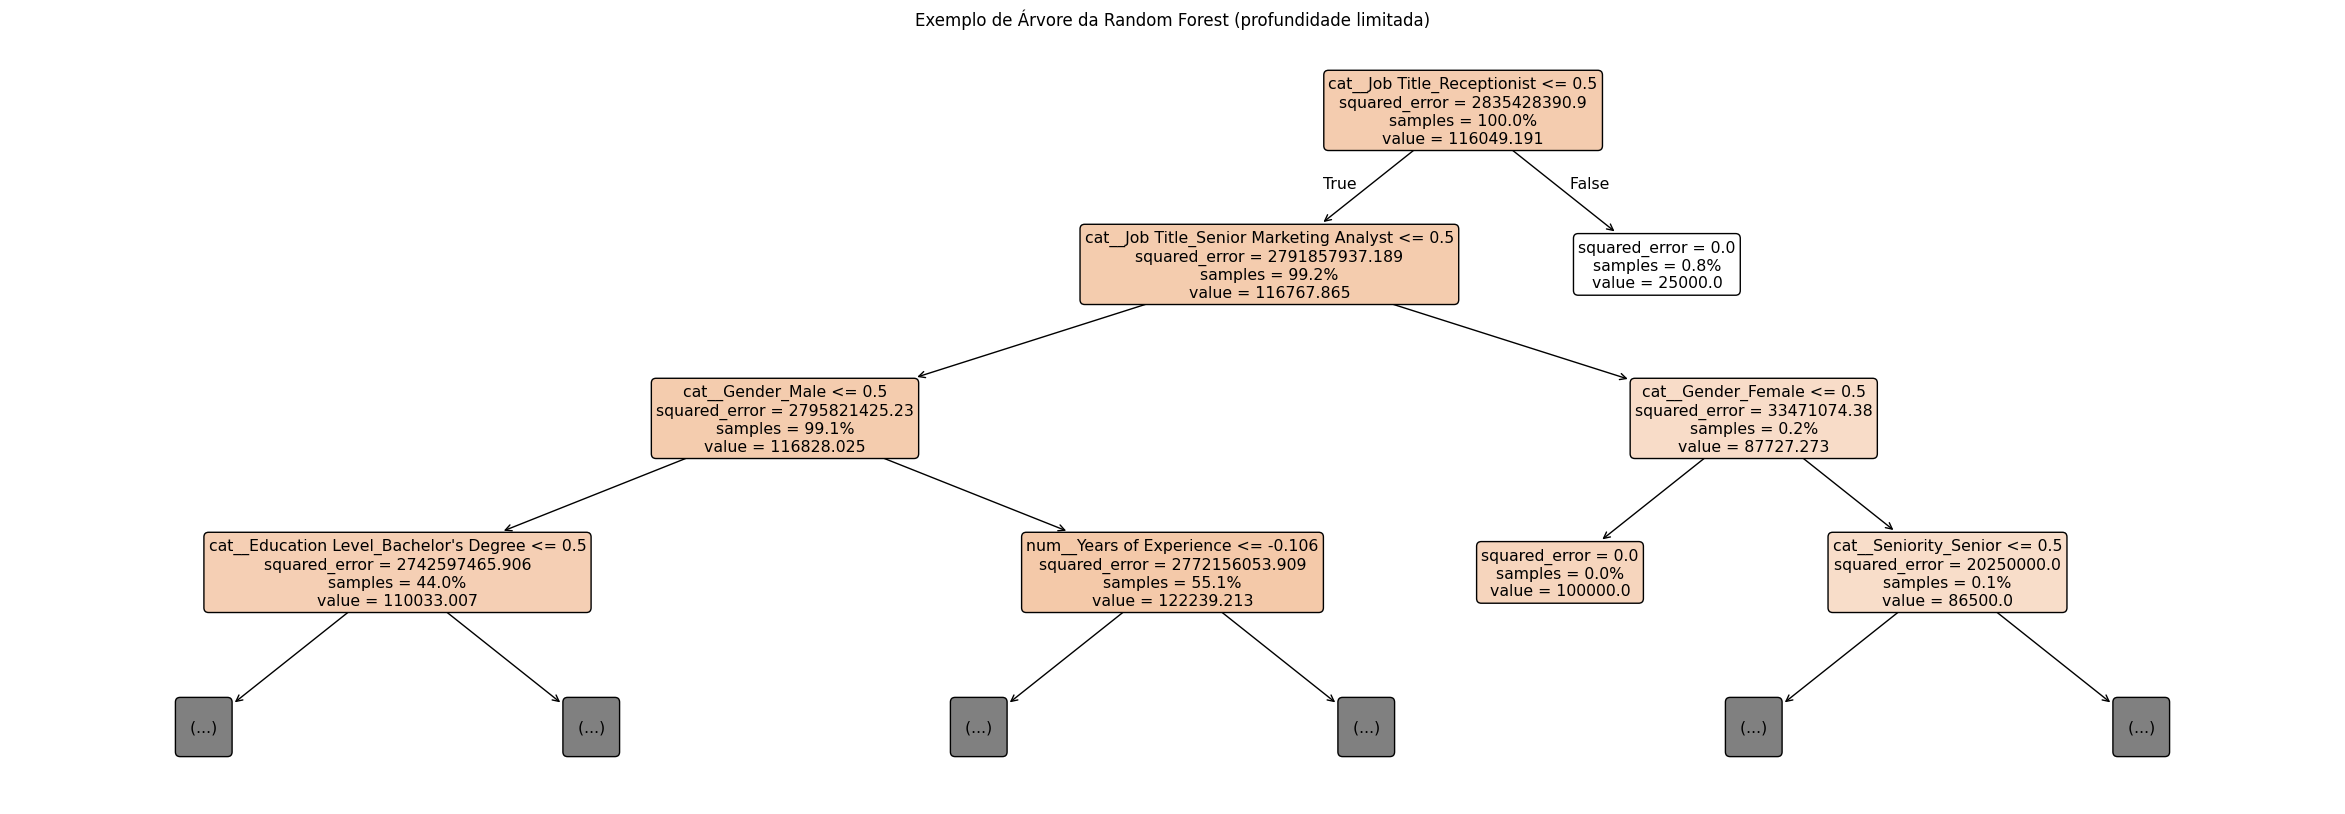

In [ ]:

best_rf = pipeline.named_steps['model'].best_estimator_
estimator = best_rf.estimators_[0]

plt.figure(figsize=(30, 10))
plot_tree(estimator,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          max_depth=3,
          proportion=True)
plt.title("Exemplo de Árvore da Random Forest (profundidade limitada)")
plt.show()

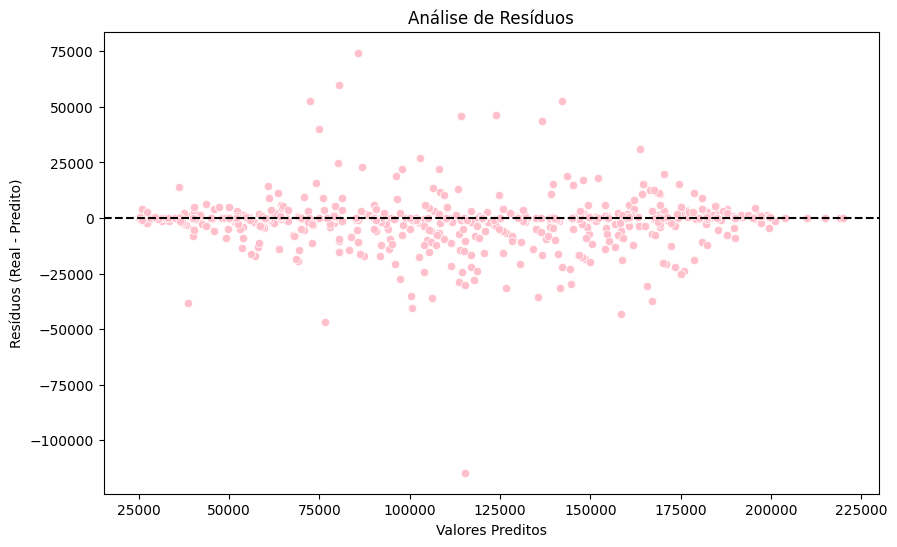

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals,color = 'pink')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Análise de Resíduos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos (Real - Predito)')
plt.show()

# XGBoost

In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Pipeline com pré-processamento + modelo
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

print("\nMSE:", mean_squared_error(y_test, y_pred_xgb))
print("R² Score:", r2_score(y_test, y_pred_xgb))



MSE: 103355740.75244357
R² Score: 0.961299938868975


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation com scoring de R²
scores = cross_val_score(pipeline_xgb, X, y, cv=5, scoring='r2')
print("R² médio (CV):", np.mean(scores))
print("Desvio padrão (CV):", np.std(scores))


R² médio (CV): 0.6945905589060412
Desvio padrão (CV): 0.38852769454675906


<ipython-input-177-32f87b2d40fa>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r',color = 'black')  # linha ideal


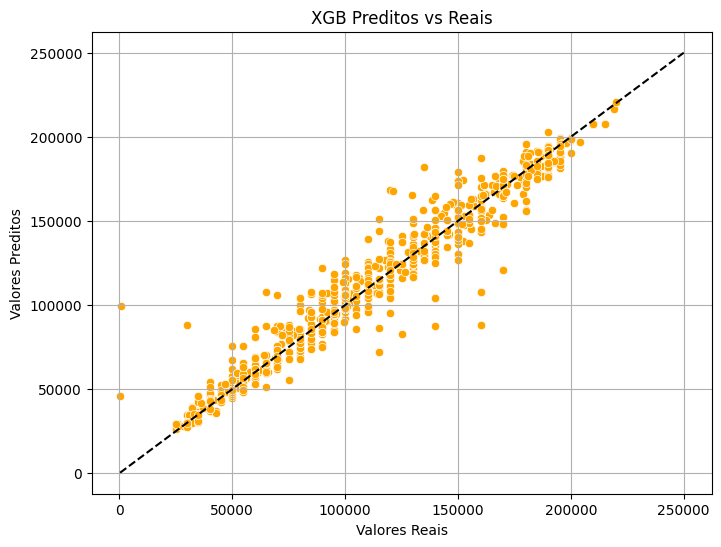

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r',color = 'black')  # linha ideal
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('XGB Preditos vs Reais')
plt.grid(True)
plt.show()


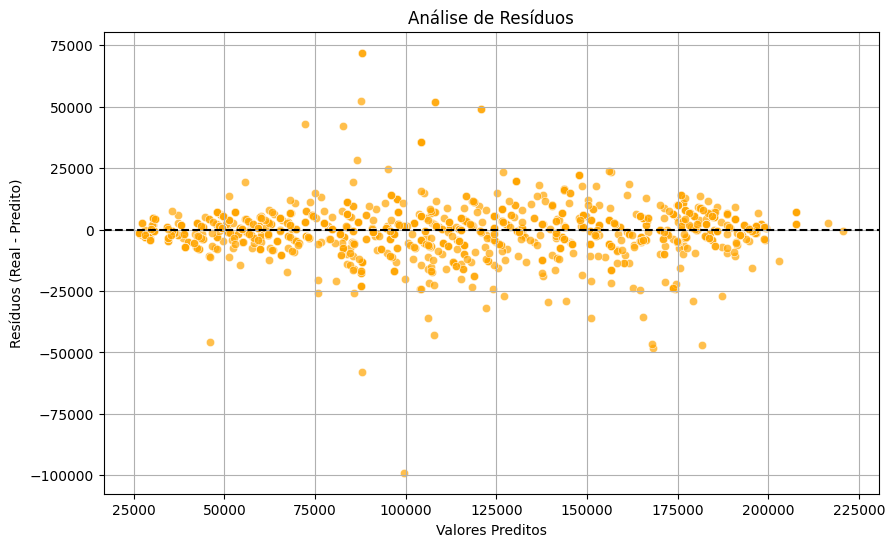

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cálculo dos resíduos
residuals_xgb = y_test - y_pred_xgb

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb, alpha=0.7,color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Análise de Resíduos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos (Real - Predito)')
plt.grid(True)
plt.show()

<ipython-input-179-0a089cec2d30>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)


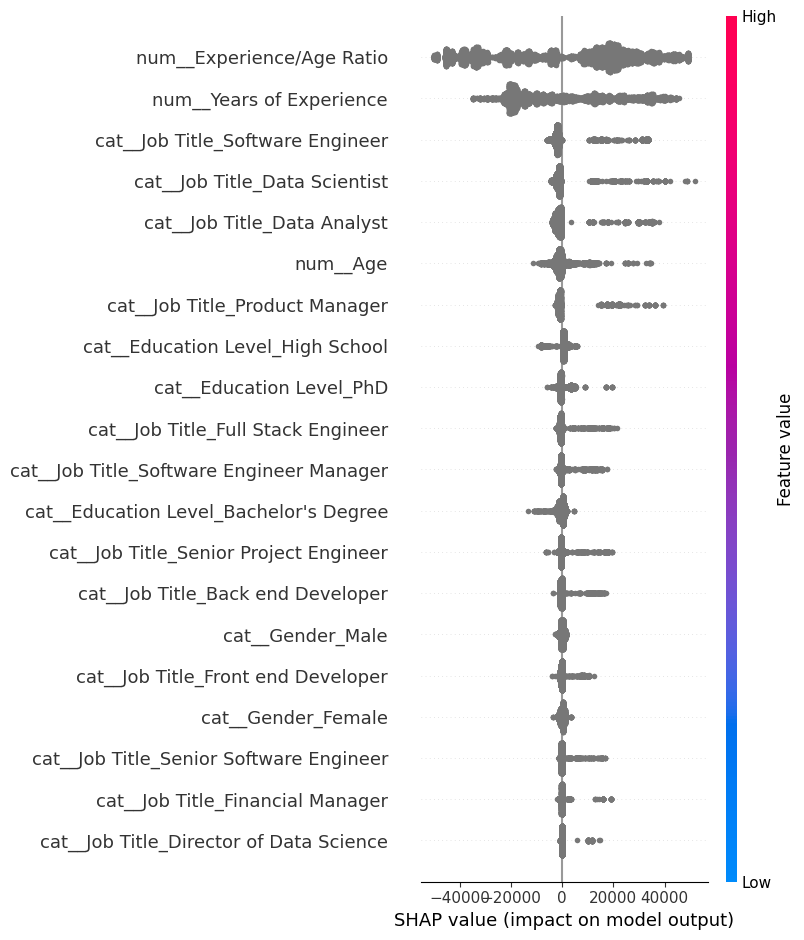

In [ ]:


# Criar um explainer com o modelo interno do XGBoost
explainer = shap.Explainer(model)
X_transformed = preprocessor.transform(X)  # pré-processar manualmente

shap_values = explainer(X_transformed)

# Gráfico de resumo das features
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

# Regressão Linear

In [ ]:
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_pipeline.fit(X_train, y_train)
y_pred_linear = linear_pipeline.predict(X_test)


mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"R² - Linear Regression: {r2_linear:.3f}")
print(f"RMSE - Linear Regression: {rmse_linear:.2f}")

R² - Linear Regression: 0.881
RMSE - Linear Regression: 17847.12


<ipython-input-181-18fc3cda114e>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r',color = 'black')  # linha ideal


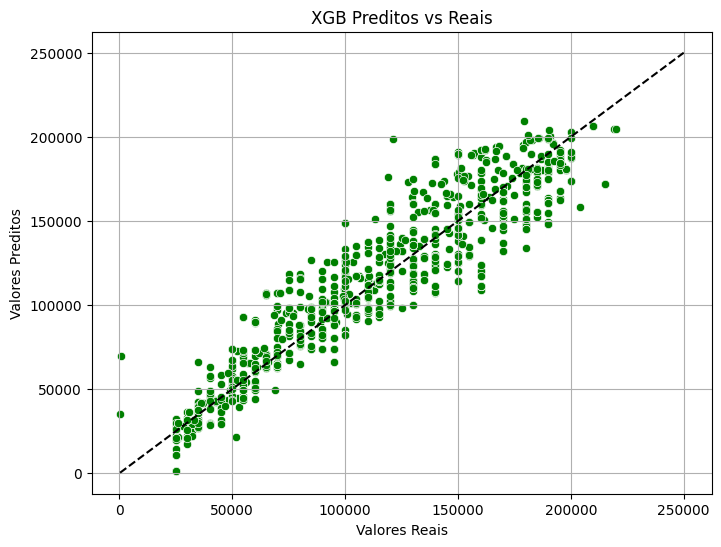

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_linear, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r',color = 'black')  # linha ideal
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('XGB Preditos vs Reais')
plt.grid(True)
plt.show()


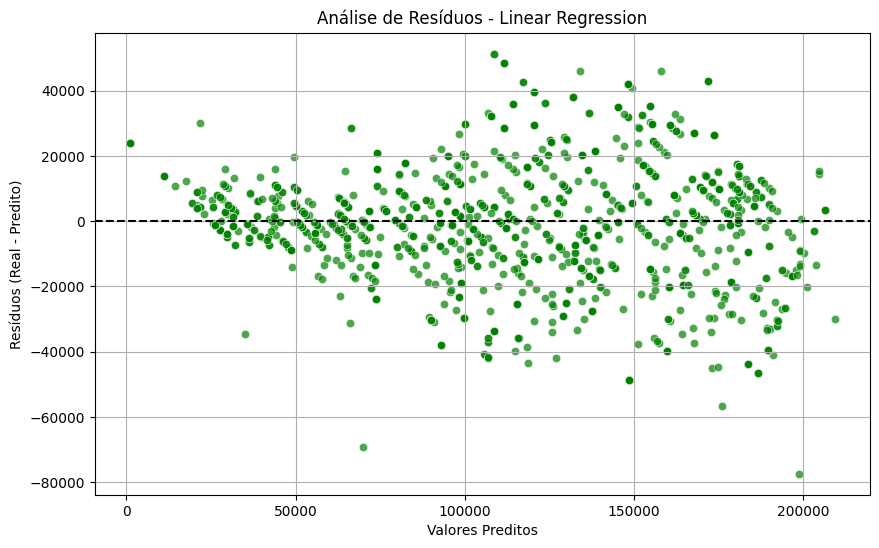

In [ ]:
residuals_linear = y_test - y_pred_linear

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_linear, y=residuals_linear, alpha=0.7, color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Análise de Resíduos - Linear Regression')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos (Real - Predito)')
plt.grid(True)
plt.show()

<ipython-input-183-e555b6b616b7>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_linear, features=X_transformed_linear, feature_names=feature_names)


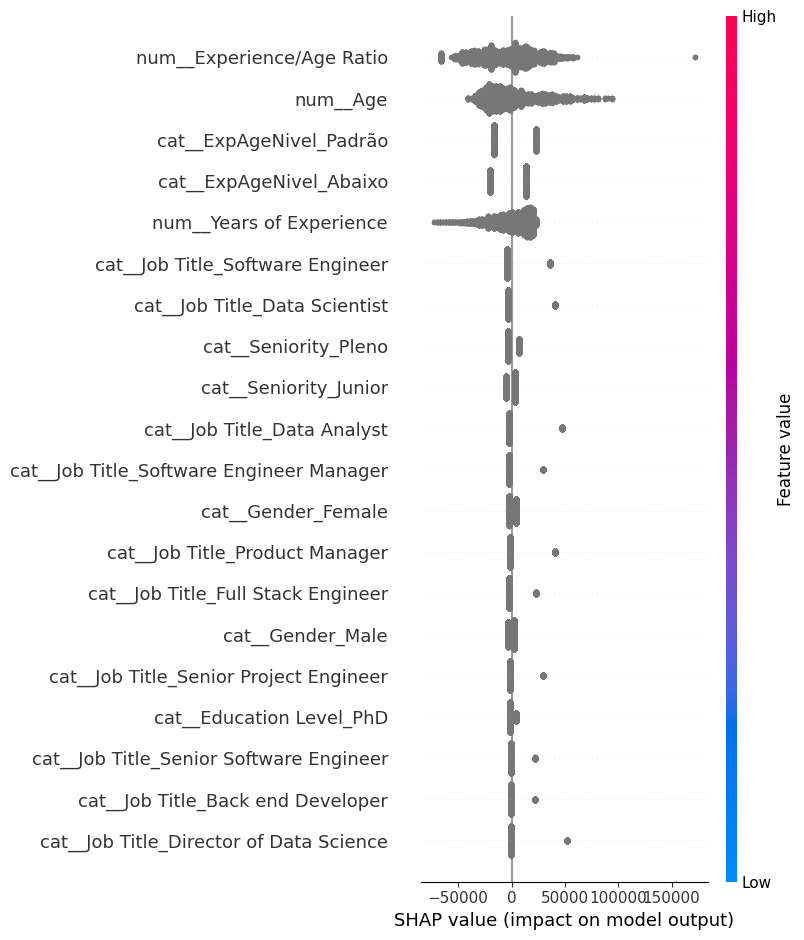

In [ ]:
import shap

X_transformed_linear = preprocessor.transform(X)
feature_names = preprocessor.get_feature_names_out()

explainer_linear = shap.Explainer(linear_pipeline.named_steps['regressor'], X_transformed_linear)
shap_values_linear = explainer_linear(X_transformed_linear)

shap.summary_plot(shap_values_linear, features=X_transformed_linear, feature_names=feature_names)


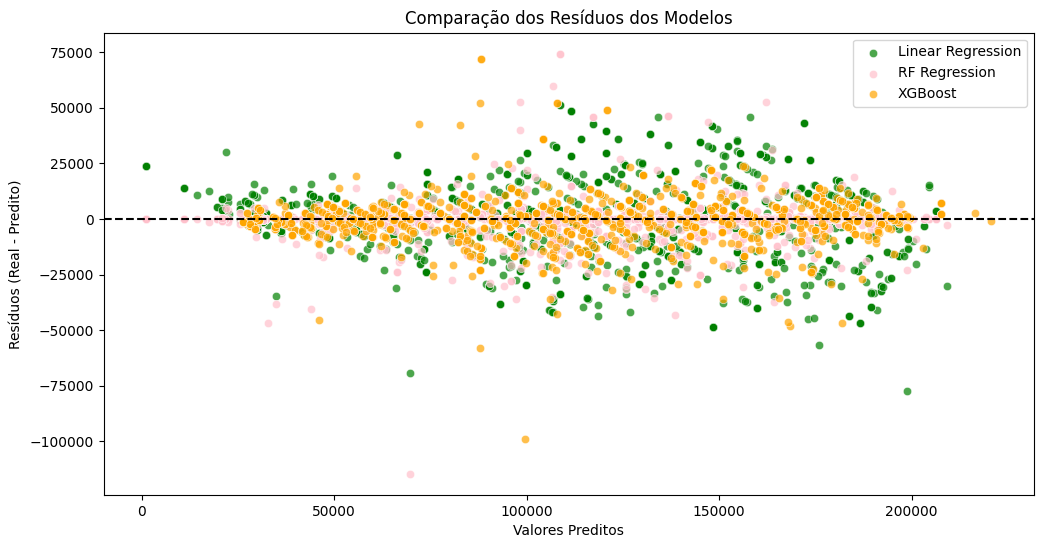

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_linear, y=y_test - y_pred_linear, color='green', label='Linear Regression', alpha=0.7)
sns.scatterplot(x=y_pred_linear, y=y_test - y_pred, color='pink', label='RF Regression', alpha=0.7)
sns.scatterplot(x=y_pred_xgb, y=y_test - y_pred_xgb, color='orange', label='XGBoost', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title('Comparação dos Resíduos dos Modelos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos (Real - Predito)')
plt.legend()
plt.show()


<ipython-input-185-7ffa0fdb5b44>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r',color = 'black')  # linha ideal


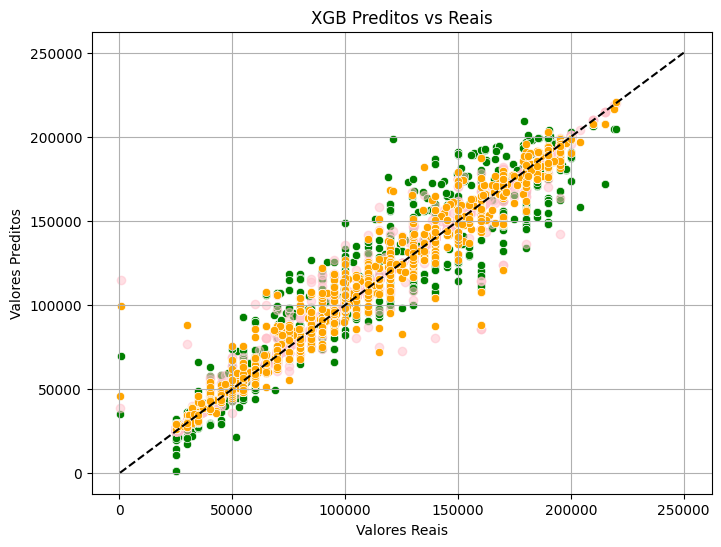

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_linear, color='green')
plt.scatter(y_test, y_pred, alpha=0.5,color = 'pink')
sns.scatterplot(x=y_test, y=y_pred_xgb, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r',color = 'black')  # linha ideal
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('XGB Preditos vs Reais')
plt.grid(True)
plt.show()
